In [55]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import grad

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class PINN(nn.Module):
    """
    Physics-Informed Neural Network (PINN) for solving the 1D Gross–Pitaevskii equation.

    This network consists of 3 hidden layers with 'tanh' activation and an output layer
    that produces a single solution value `u(x)` without activation.

    Attributes
    ----------
    hidden_layers : nn.ModuleList
        List of three linear layers with 32 units each and 'tanh' activation.
    output_layer : nn.Linear
        Output layer with a single unit and no activation.
    """

    def __init__(self):
        super(PINN, self).__init__()
        self.hidden_layers = nn.ModuleList([nn.Linear(2, 32), nn.Linear(32, 32), nn.Linear(32, 32)])
        self.output_layer = nn.Linear(32, 1)

    def forward(self, x):
        """
        Forward pass through the network.

        Parameters
        ----------
        x : torch.Tensor
            Input tensor containing spatial points [x, y].

        Returns
        -------
        torch.Tensor
            Output tensor representing the predicted solution `u(x, y)`.
        """
        for layer in self.hidden_layers:
            x = torch.tanh(layer(x))
        return self.output_layer(x)


def rayleigh_quotient(model, x, eta, u, u_x, u_y):
    """
    Computes the Rayleigh quotient for the given model output to estimate the eigenvalue.

    Parameters
    ----------
    model : PINN
        The PINN model used for approximating the solution.
    x : torch.Tensor
        Input tensor for which to compute the Rayleigh quotient.
    eta : float
        Nonlinearity parameter for the equation.
    u : torch.Tensor
        Model output for the given input.
    u_x : torch.Tensor
        First derivative of the model output with respect to the input x.

   u_y : torch.Tensor
        First derivative of the model output with respect to the input y.

    Returns
    -------
    torch.Tensor
        The Rayleigh quotient, an estimate of the eigenvalue.
    """
    numerator = torch.mean(u_x**2 + u_y**2 + 0.5 * eta * u**4)
    denominator = torch.mean(u**2)
    return numerator / denominator


def compute_derivatives(model, x):
    """
    Compute the necessary derivatives of the solution `u(x, y)` with respect to x and y.

    Parameters
    ----------
    model : PINN
        The PINN model used to approximate the solution.
    x : torch.Tensor
        Input tensor for which to compute the derivatives.

    Returns
    -------
    tuple of torch.Tensor
        The first derivative `u_x`, second derivative `u_xx`,
        first derivative `u_y`, and second derivative `u_yy`.
    """
    u = model(x)
    u_x = grad(u, x, torch.ones_like(u), create_graph=True)[0][:, 0:1]  # u_x derivative with respect to x
    u_y = grad(u, x, torch.ones_like(u), create_graph=True)[0][:, 1:2]  # u_y derivative with respect to y
    u_xx = grad(u_x, x, torch.ones_like(u_x), create_graph=True)[0][:, 0:1]  # u_xx second derivative with respect to x
    u_yy = grad(u_y, x, torch.ones_like(u_y), create_graph=True)[0][:, 1:2]  # u_yy second derivative with respect to y

    return u, u_x, u_y, u_xx, u_yy


def compute_loss(model, x, eta, B, N):
    """
    Compute the total loss, including Rayleigh quotient, boundary, normalization, and PDE residual losses.

    Parameters
    ----------
    model : PINN
        The PINN model for solving the equation.
    x : torch.Tensor
        Input tensor for computing the loss.
    eta : float
        Nonlinearity parameter for the equation.
    B : float
        Weighting factor for the boundary loss.
    N : float
        Weighting factor for the normalization loss.

    Returns
    -------
    tuple of torch.Tensor
        The total loss and Rayleigh quotient loss.
    """
    x.requires_grad_(True)
    u, u_x, u_y, u_xx, u_yy = compute_derivatives(model, x)

    rayleigh_loss = rayleigh_quotient(model, x, eta, u, u_x, u_y)
    boundary_loss = torch.mean((model(torch.tensor([[0.0, 0.0], [1.0, 1.0]], device=device)) - 0.0)**2)
    norm_loss = (torch.mean(u**2) - 1.0)**2

    # PDE residual: ∇²u + η * u⁴ + λu = 0
    residual = u_xx + u_yy + eta * u**4 + rayleigh_loss * u
    pde_loss = torch.mean(residual**2)

    total_loss = rayleigh_loss + B * boundary_loss + N * norm_loss + pde_loss
    return total_loss, rayleigh_loss


def gaussian_potential(x, y, sigma=0.1):
    """
    Compute the Gaussian potential inside the unit square [0, 1] x [0, 1].

    Parameters
    ----------
    x : numpy.ndarray
        x coordinates of the grid.
    y : numpy.ndarray
        y coordinates of the grid.
    sigma : float, optional
        The width of the Gaussian potential (default is 0.1).

    Returns
    -------
    numpy.ndarray
        The Gaussian potential values at the grid points.
    """
    return np.exp(-((x - 0.5)**2 + (y - 0.5)**2) / (2 * sigma**2))

def plot_potential(X_test, potential):
    """
    Plot the potential as a contour plot.
    """
    X = X_test[:, 0]
    Y = X_test[:, 1]
    potential = potential.reshape((np.size(X), np.size(Y)))

    plt.figure(figsize=(6, 5))
    plt.contourf(X, Y, potential, levels=50, cmap='viridis')
    plt.colorbar()
    plt.title('Potential V(x, y)')
    plt.show()


def train_model(model, x_train, epochs, optimizer, eta, B, N):
    """
    Trains the PINN model to solve the 2D Gross–Pitaevskii equation.

    Parameters
    ----------
    model : PINN
        The PINN model to be trained.
    x_train : torch.Tensor
        Training data points in the domain [0, 1] x [0, 1].
    epochs : int
        Number of training epochs.
    optimizer : torch.optim.Optimizer
        Optimizer for training the model.
    eta : float
        Nonlinearity parameter for the equation.
    B : float
        Weighting factor for the boundary loss.
    N : float
        Weighting factor for the normalization loss.
    """

    # Reshape x_train for plotting
    num_grid_pts = int(np.sqrt(len(x_train)))
    x_train_reshaped = x_train.detach().cpu().numpy().reshape((num_grid_pts, num_grid_pts, 2))

    for epoch in range(epochs):
        optimizer.zero_grad()
        loss, rayleigh_loss = compute_loss(model, x_train, eta, B, N)
        loss.backward()
        optimizer.step()

        if epoch % 2000 == 0:
            with torch.no_grad():
                u_pred = model(x_train).cpu().numpy()
                u_pred = np.abs(u_pred) / np.max(np.abs(u_pred))  # Normalize the prediction

                # Reshape u_pred for plotting
                u_pred_reshaped = u_pred.reshape((num_grid_pts, num_grid_pts))

                # Extract x and y coordinates from the reshaped grid
                X_test = x_train_reshaped[:, :, 0]
                Y_test = x_train_reshaped[:, :, 1]
                potential = gaussian_potential(X_test, Y_test, sigma=0.1)

                fig, ax = plt.subplots(1, 2, figsize=(16, 6))

                # Plot predicted solution
                contour1 = ax[0].contourf(X_test, Y_test, u_pred_reshaped, levels=50, cmap='viridis')
                fig.colorbar(contour1, ax=ax[0])
                ax[0].set_title(f'Predicted Solution (η ≈ {eta}) at Epoch {epoch}')
                ax[0].set_xlabel('x')
                ax[0].set_ylabel('y')
                ax[0].grid(True)

                # Plot potential
                # contour2 = ax[1].contourf(X_test, Y_test, potential, levels=50, cmap='viridis')
                Z = np.sin(np.pi * X_test) * np.sin(np.pi * Y_test)
                contour2 = ax[1].contourf(X_test, Y_test, Z, levels=50, cmap='viridis')
                fig.colorbar(contour2, ax=ax[1])
                ax[1].set_title('Potential V(x, y)')
                ax[1].set_xlabel('x')
                ax[1].set_ylabel('y')
                ax[1].grid(True)

                plt.tight_layout()
                plt.show()

            print(f'Epoch {epoch}: Loss = {loss.item():.5e}, Rayleigh Quotient λ = {rayleigh_loss.item():.5f}')

# Create PINN and Training/Plotting Functions

# Train PINN

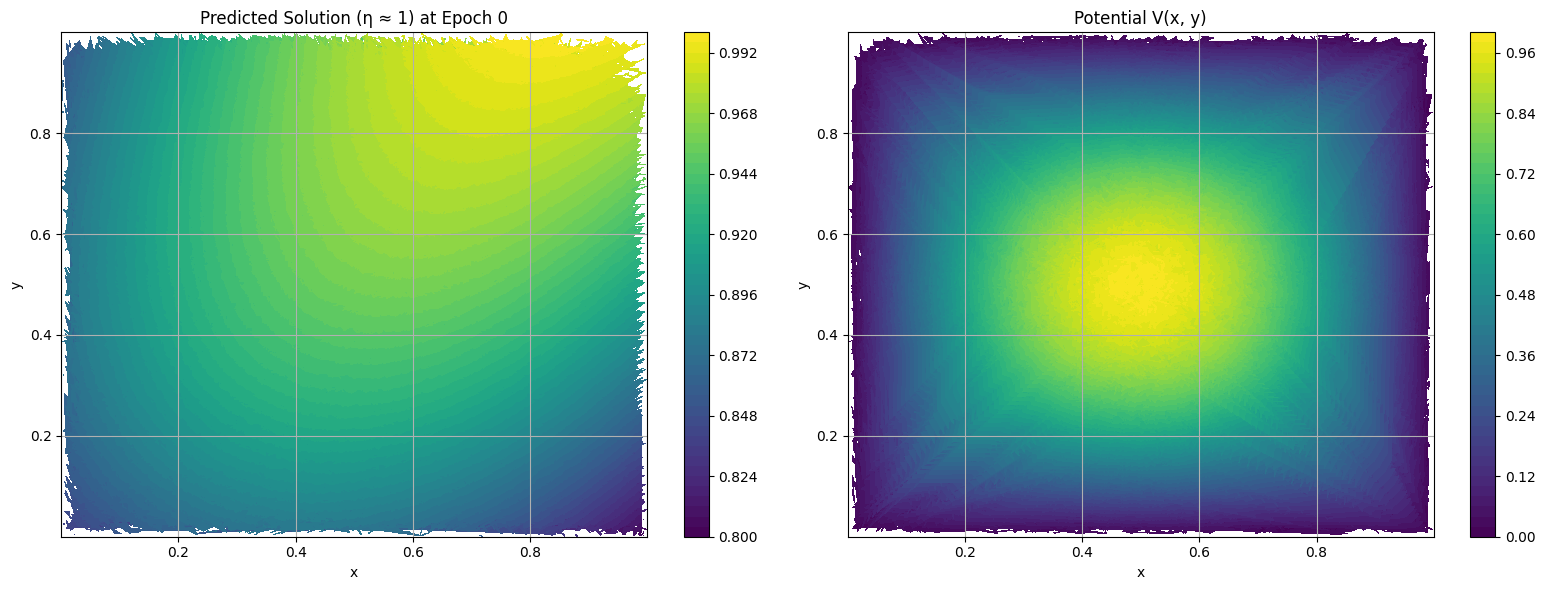

Epoch 0: Loss = 1.00094e+03, Rayleigh Quotient λ = 0.16457


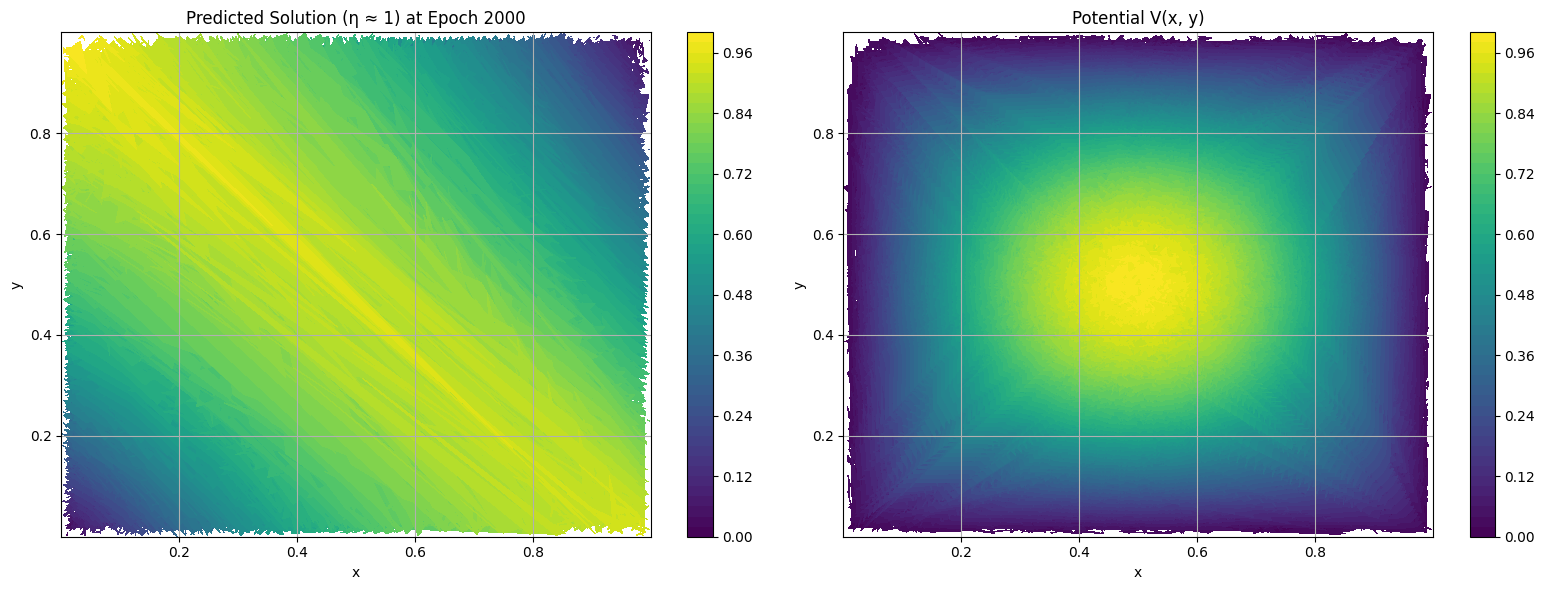

Epoch 2000: Loss = 2.57282e+00, Rayleigh Quotient λ = 2.25217


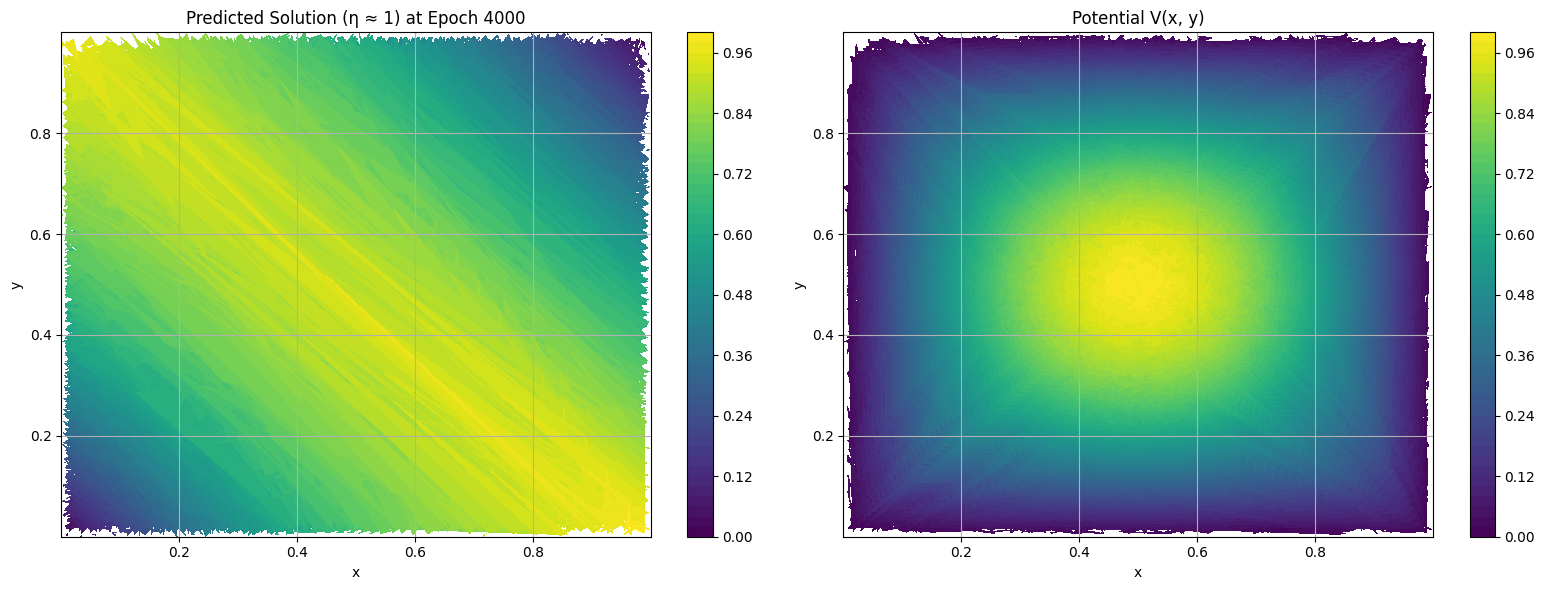

Epoch 4000: Loss = 2.29786e+00, Rayleigh Quotient λ = 2.16987


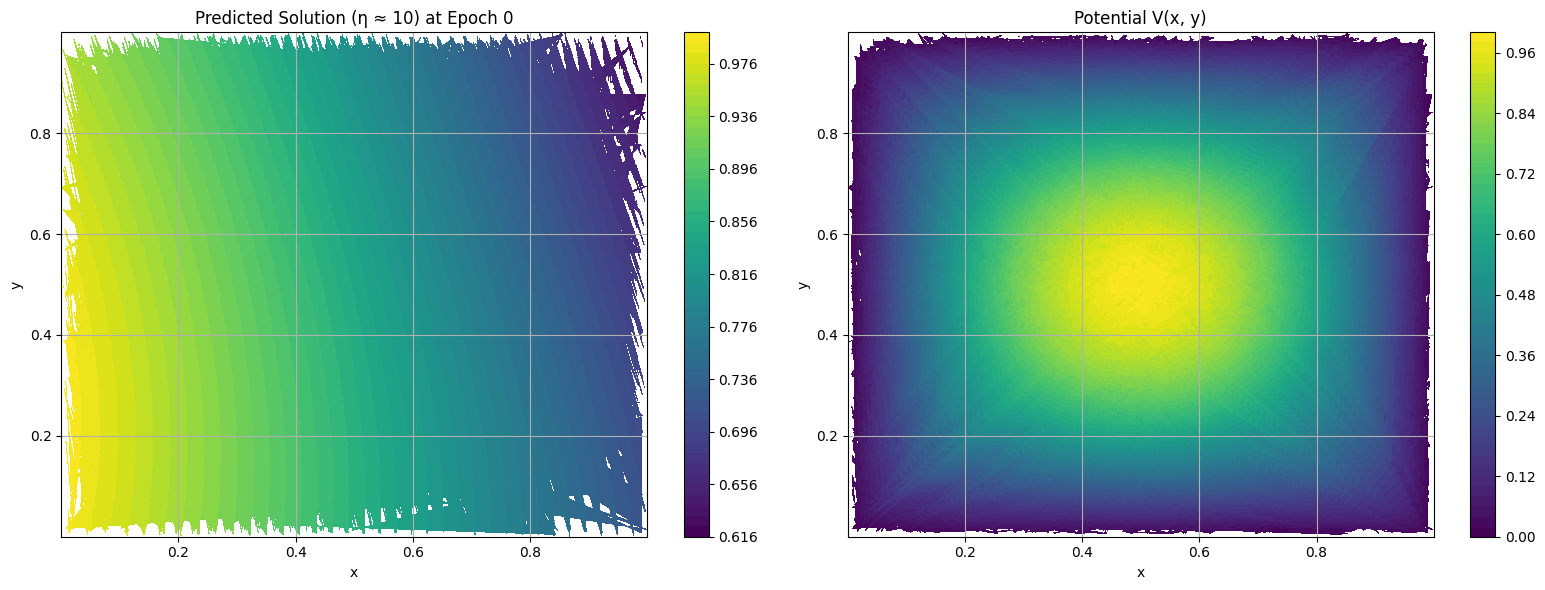

Epoch 0: Loss = 1.00511e+03, Rayleigh Quotient λ = 0.48369


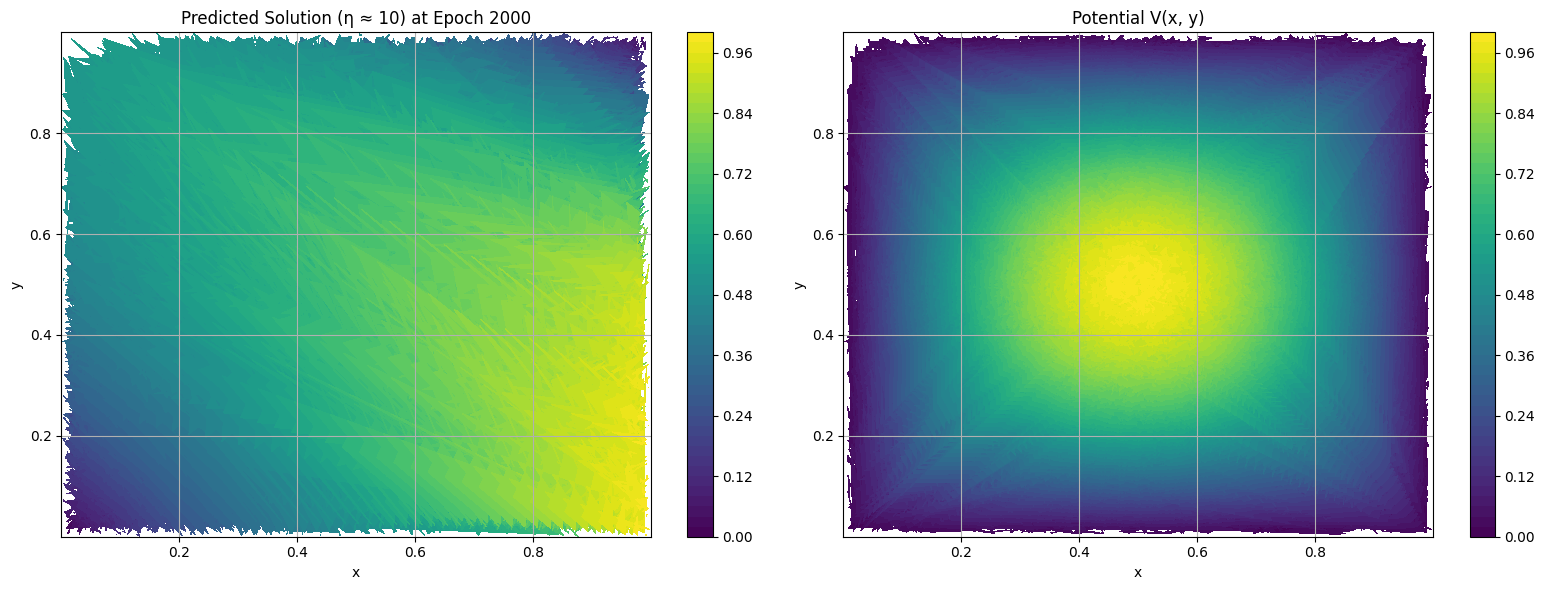

Epoch 2000: Loss = 1.07034e+01, Rayleigh Quotient λ = 9.62472


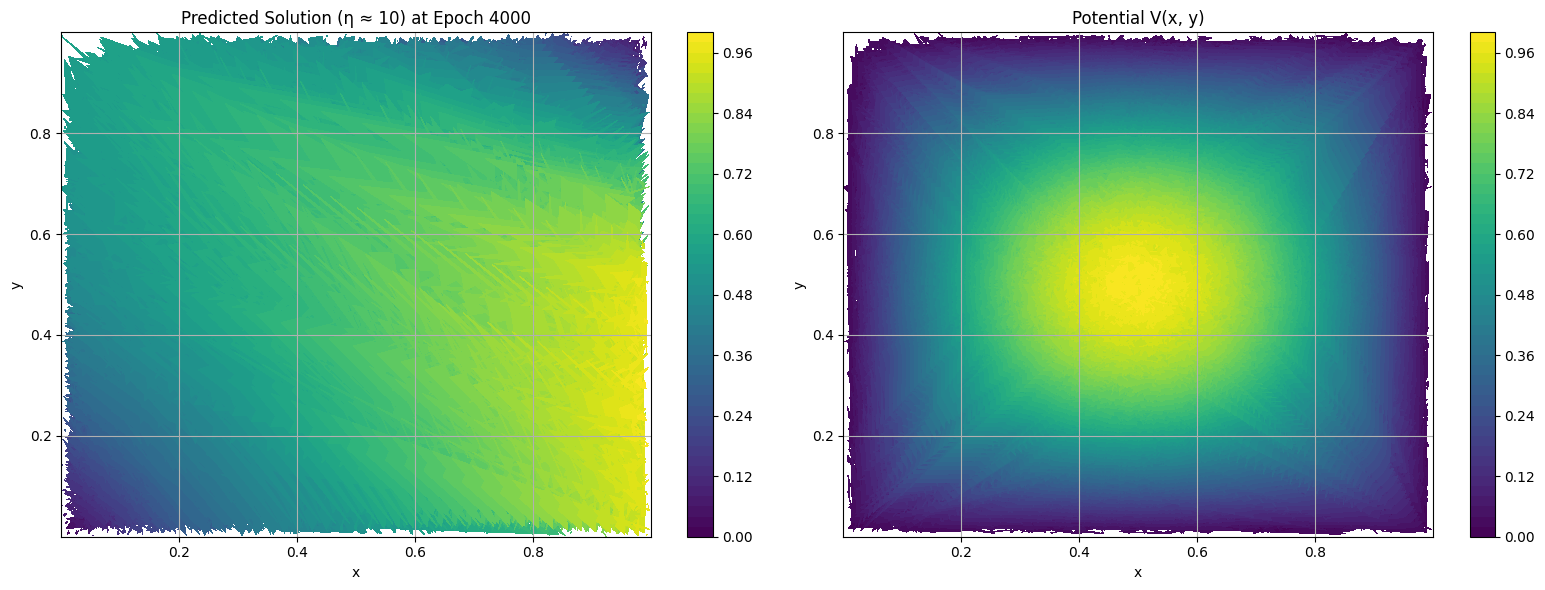

Epoch 4000: Loss = 9.67086e+00, Rayleigh Quotient λ = 9.33198


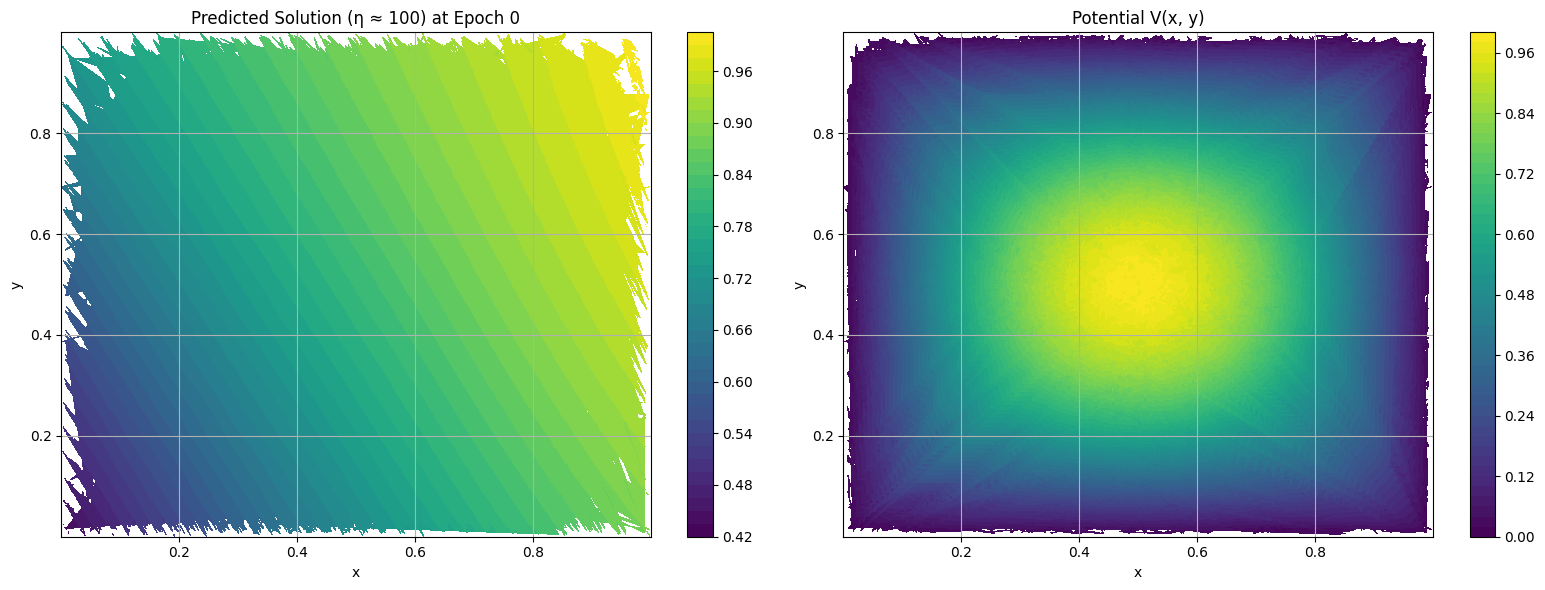

Epoch 0: Loss = 1.00332e+03, Rayleigh Quotient λ = 2.01405


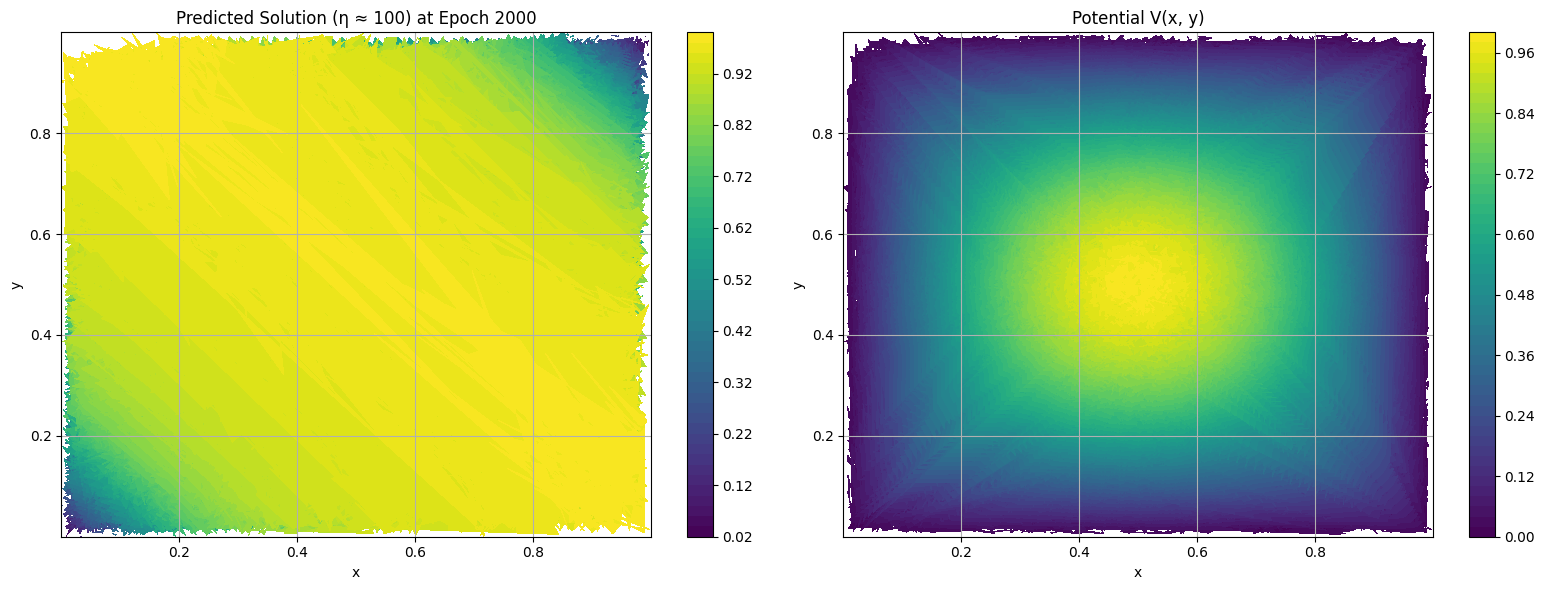

Epoch 2000: Loss = 3.68332e+02, Rayleigh Quotient λ = 28.08011


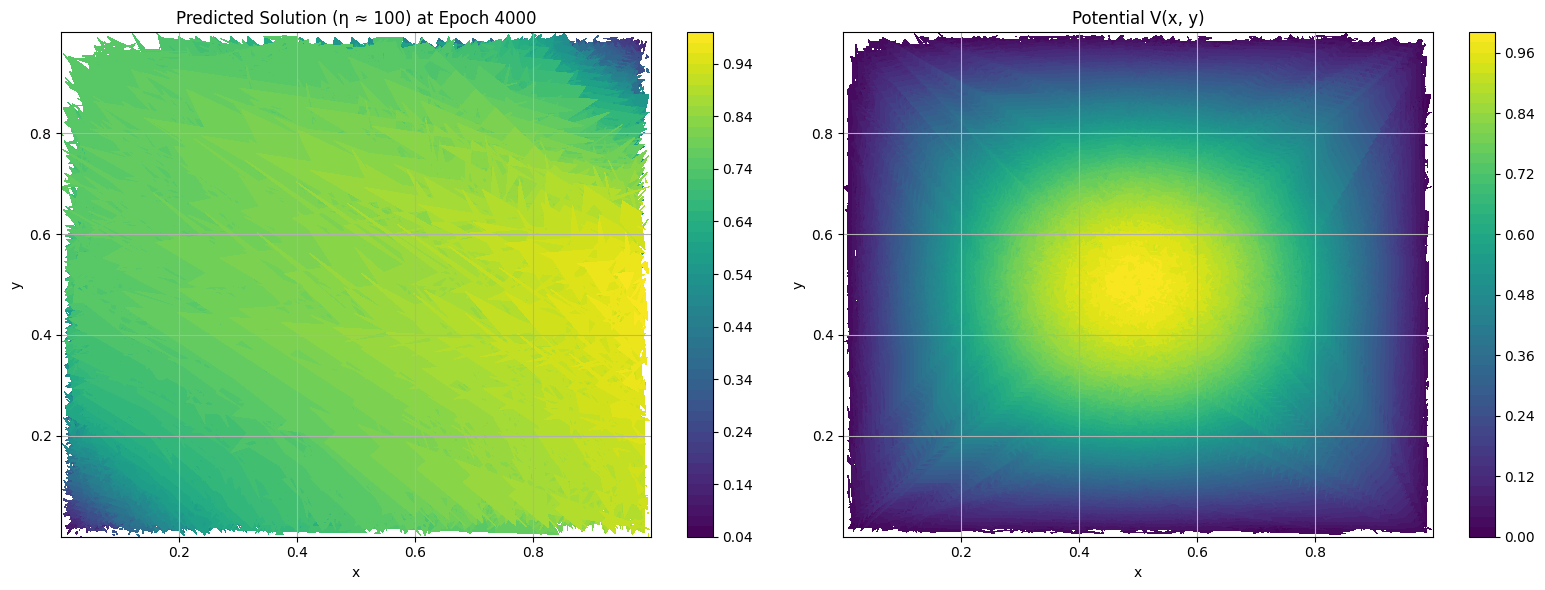

Epoch 4000: Loss = 3.18872e+02, Rayleigh Quotient λ = 28.47207


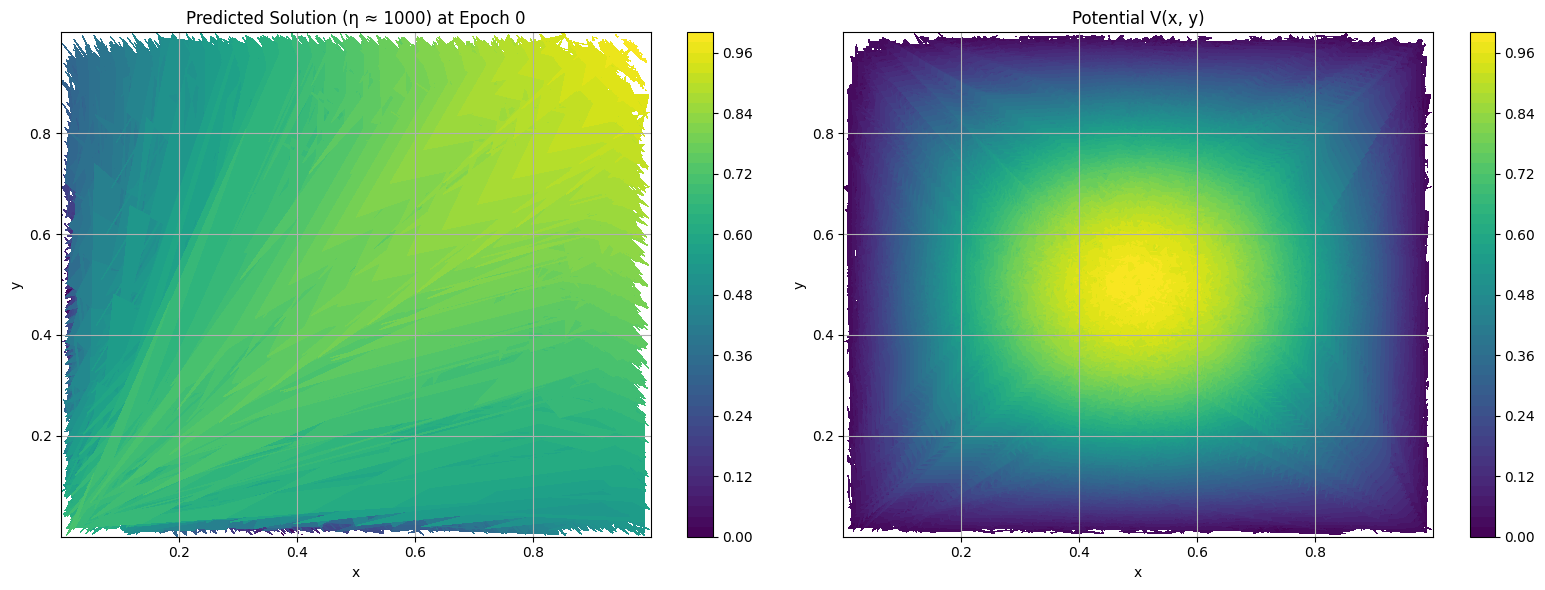

Epoch 0: Loss = 1.00089e+03, Rayleigh Quotient λ = 0.49882


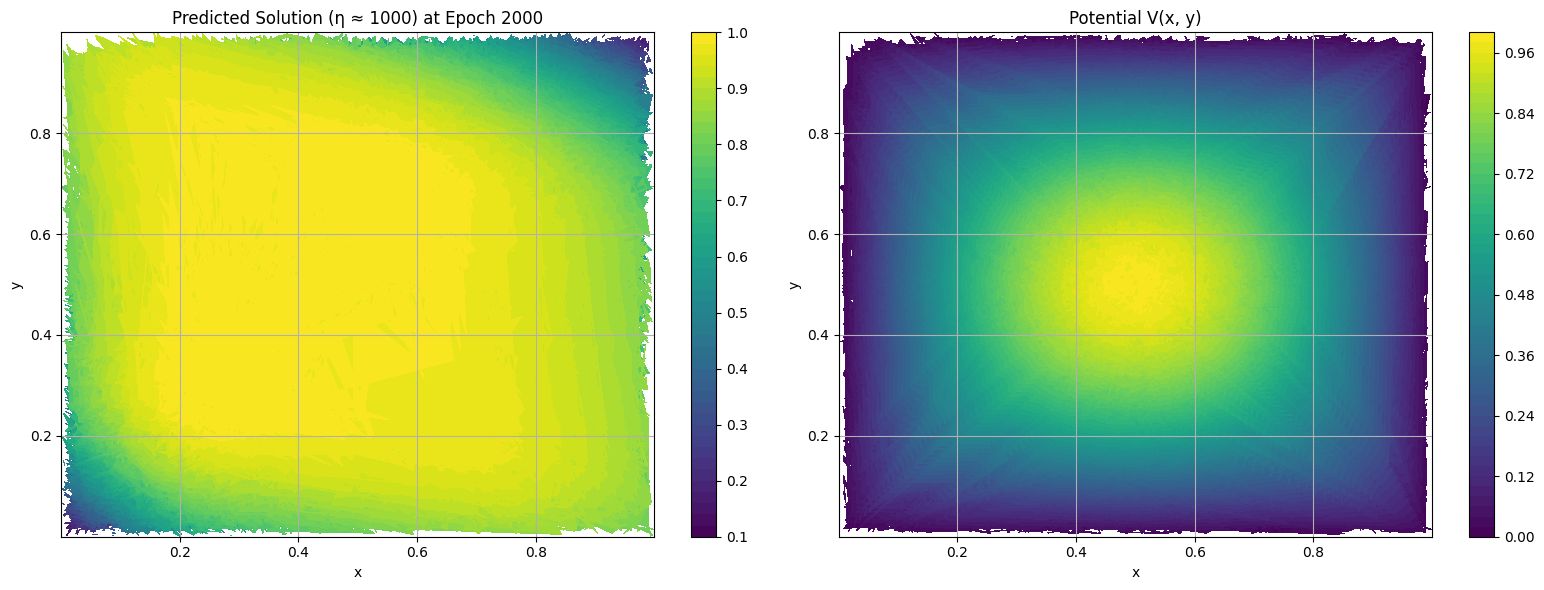

Epoch 2000: Loss = 9.68264e+02, Rayleigh Quotient λ = 17.99787


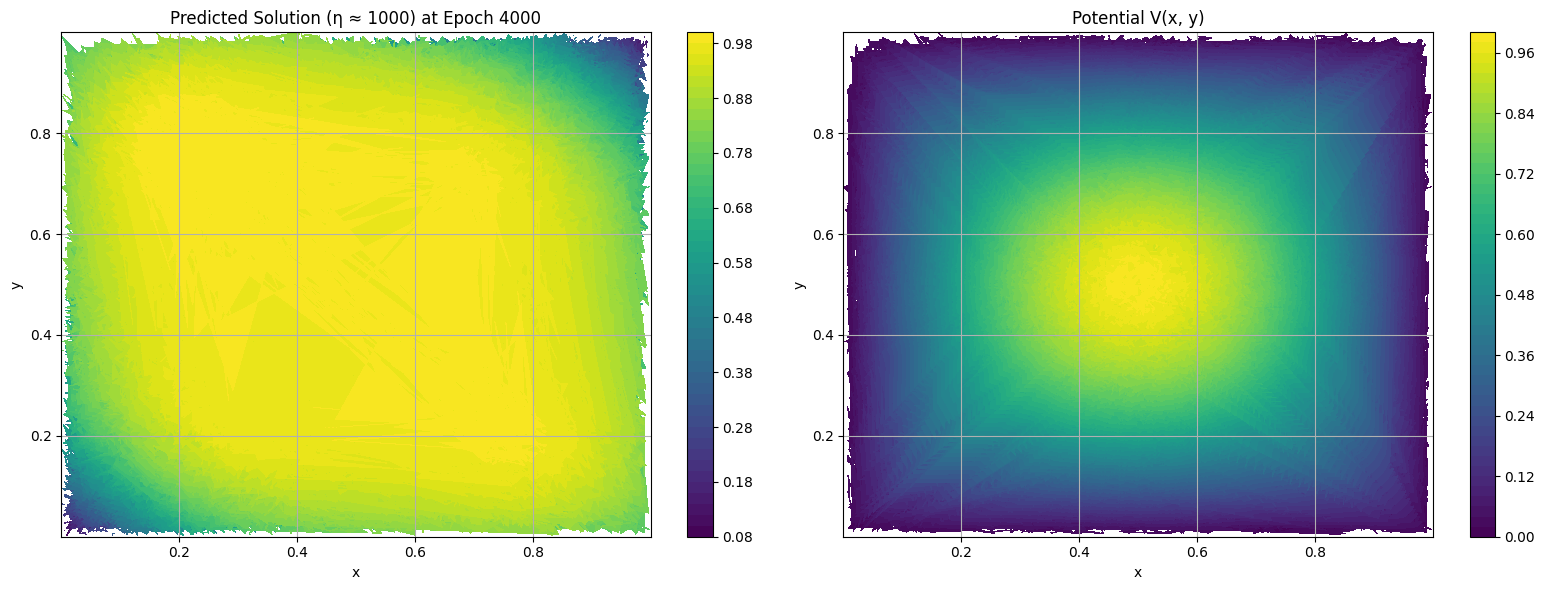

Epoch 4000: Loss = 9.66893e+02, Rayleigh Quotient λ = 19.39426


In [56]:
# Generate 2D training data points in the domain [0, 1] x [0, 1]
N_train = 10000
x_train = torch.rand(N_train, 2).to(device)

# Initialize models, eta values, and parameters for the loss functions
models = [PINN().to(device) for _ in range(4)]
etas = [1, 10, 100, 1000]
Bs = [2000, 2000, 2000, 2000]
Ns = [1000, 1000, 1000, 1000]
epochs_list = [4001, 4001, 4001, 4001]

# Train the models
for model, eta, B, N, epochs in zip(models, etas, Bs, Ns, epochs_list):
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    train_model(model, x_train, epochs, optimizer, eta, B, N)

# Plot Final Predicted Solution

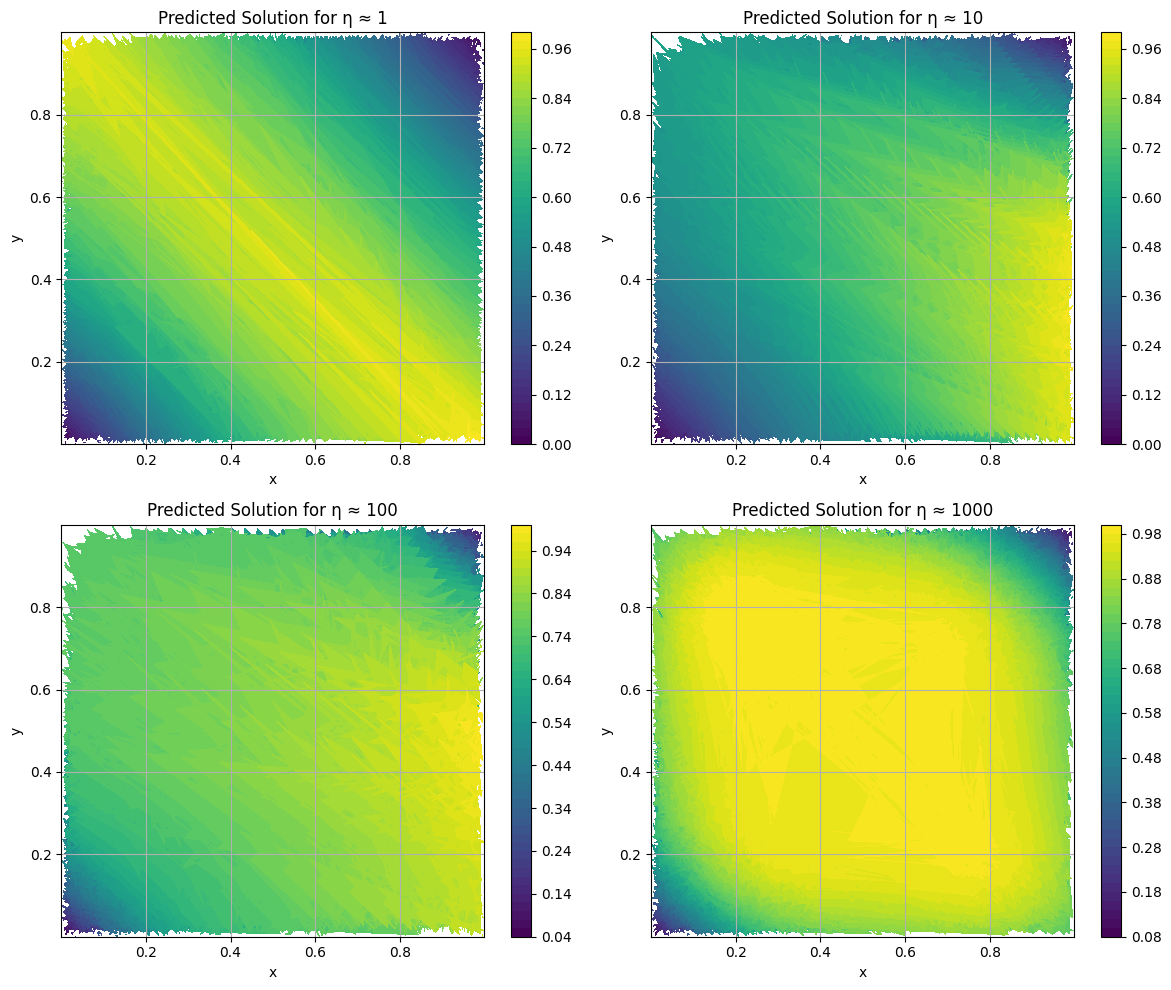

In [57]:
# Final plot of the predicted solution as 2D contour plots

fig, ax = plt.subplots(2, 2, figsize=(12, 10))
ax = ax.flatten()

for i, (model, eta) in enumerate(zip(models, etas)):
    with torch.no_grad():
        u_pred = model(x_train).cpu().numpy()
        u_pred = np.abs(u_pred) / np.max(np.abs(u_pred))  # Normalize the prediction

        # Reshape the prediction into a 2D grid for plotting
        num_grid_pts = int(np.sqrt(len(x_train)))
        u_pred_reshaped = u_pred.reshape((num_grid_pts, num_grid_pts))

        # Extract x and y coordinates from the grid
        X_test = x_train.cpu().numpy()[:, 0].reshape((num_grid_pts, num_grid_pts))
        Y_test = x_train.cpu().numpy()[:, 1].reshape((num_grid_pts, num_grid_pts))

        # Plot the predicted solutions
        contour = ax[i].contourf(X_test, Y_test, u_pred_reshaped, levels=50, cmap='viridis')
        fig.colorbar(contour, ax=ax[i])
        ax[i].set_title(f'Predicted Solution for η ≈ {eta}')
        ax[i].set_xlabel('x')
        ax[i].set_ylabel('y')
        ax[i].grid(True)

plt.tight_layout()
plt.show()
